# Homework Report and Analysis
## Personal Details

**Name:** Maria Calvo

**Date:** 3/12/2025

**Course:** Data Science Meets Health

**Instructor:** Dr. Olmo S. Zavala Romero

## Homework Questions and Answers

### Code to 1. Implement Custom Dataset

In [1]:
#  1. Implement Custom Dataset

import os
import sys

sys.path.insert(0, os.path.abspath("/Users/mariacalvo/Desktop/hm-professional-pytorch-template-mariaccalvo"))

import torch
import numpy as np
from base.base_data_loader import BaseDataLoader
from torch.utils.data import Dataset

class FunctionsDataset(Dataset):
    def __init__(self, n_samples=100, function='linear'):
        self.n_samples = n_samples
        self.function = function

        # generate values of x randomly between 0 and 2pi
        self.x = np.random.uniform(0, 2 * np.pi, self.n_samples)

        # generate values of y based on function type and noise (epsilon between -1 and 1)
        epsilon = np.random.uniform(-1, 1, self.n_samples)
        if self.function == 'linear':
            self.y = 1.5 * self.x + 0.3 + epsilon
        elif self.function == 'quadratic':
            self.y = 2 * (self.x ** 2) + 0.5 * self.x + 0.3 + epsilon
        elif self.function == 'harmonic':
            self.y = 0.5 * (self.x ** 2) + 5 * np.sin(self.x) + 3 * np.cos(3 * self.x) + 2 + epsilon
        else:
            raise ValueError(f"Unknown function type: {self.function}. Function options only are linear, quadratic, and harmonic")

        # normalize x and y
        self.x = (self.x - np.mean(self.x)) / np.std(self.x)
        self.y = (self.y - np.mean(self.y)) / np.std(self.y)

        self.x = torch.tensor(self.x, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(self.y, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

class FunctionDataLoader(BaseDataLoader):
    def __init__(self, data_dir, batch_size, shuffle=True, validation_split=0.0, num_workers=1, function='linear', n_samples=100):
        self.dataset = FunctionDataset(n_samples=n_samples, function=function)
        super().__init__(self.dataset, batch_size, shuffle, validation_split, num_workers)

### Code to 2. Implement Model Architecture

In [2]:
#  2. Implement Model Architecture 

import torch
import torch.nn as nn
from torch.optim import Adam

# activation functions
activations = {
    'relu': nn.ReLU,
    'sigmoid': nn.Sigmoid,
    'tanh': nn.Tanh,
    'linear': nn.Identity  
}

# base model definition
class BaseModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size

    def save_model(self, path):
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()

    def train_model(self, dataloader, criterion, optimizer, num_epochs=10):
        for epoch in range(num_epochs):
            self.train() 
            running_loss = 0.0
            for inputs, labels in dataloader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}")

    def evaluate_model(self, dataloader, criterion):
        self.eval()  
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in dataloader:
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
        print(f"Validation Loss: {running_loss/len(dataloader)}")

# dense model definition
class DenseModel(BaseModel):
    def __init__(self, input_size, output_size, hidden_layers=1, neurons_per_layer=10, activation_hidden='relu', activation_output='linear'):
        super().__init__(input_size, output_size)

        # check activation function
        if activation_hidden not in activations:
            raise ValueError(f"Unknown activation function: {activation_hidden}. Activation options only are relu, sigmoid, tanh, and linear.")

        # list of layers
        layers = []

        # input layer
        layers.append(nn.Linear(input_size, neurons_per_layer))

        # hidden layers
        for _ in range(hidden_layers):
            layers.append(activations[activation_hidden]())  
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))

        # output layer
        layers.append(activations[activation_output]())   
        layers.append(nn.Linear(neurons_per_layer, output_size))

        # combine all layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

### Code to 3. Implement Training Metrics

In [3]:
import torch

class Metrics:
    @staticmethod
    def calculate_loss(predictions, targets):
        loss = torch.mean((predictions - targets) ** 2)
        return loss

    @staticmethod
    def calculate_accuracy(predictions, targets):
        correct = torch.abs(predictions - targets) < 0.05  
        accuracy = torch.mean(correct.float()) 
        return accuracy

    @staticmethod
    def calculate_validation_loss(predictions, targets):
        return Metrics.calculate_loss(predictions, targets)

    @staticmethod
    def log_metrics(epoch, train_loss, val_loss, train_accuracy=None, val_accuracy=None):
        if train_accuracy is not None and val_accuracy is not None:
            print(f"Epoch: {epoch}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}, "
                  f"Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")
        else:
            print(f"Epoch: {epoch}, Train Loss: {train_loss:.3f}, Validation Loss: {val_loss:.3f}")

### Code to 4. Configuration Files

In [4]:
#  4. Configuration Files
# config.json
{
        "input_size": 1,
        "output_size": 1,
        "hidden_layers": 2,
        "neurons_per_layer": 75,
        "activation_hidden": "relu",
        "activation_output": "linear",
        "batch_size": 16,
        "epochs": 100,
        "learning_rate": 0.001
    }


# optimal.json
{
        "input_size": 1,
        "output_size": 1,
        "hidden_layers": 2,
        "neurons_per_layer": 75,
        "activation_hidden": "relu",
        "activation_output": "linear",
        "batch_size": 16,
        "epochs": 100,
        "learning_rate": 0.001
}


# overfit.json
{
        "input_size": 1,
        "output_size": 1,
        "hidden_layers": 4,
        "neurons_per_layer": 100,
        "activation_hidden": "relu",
        "activation_output": "linear",
        "batch_size": 16,
        "epochs": 100,
        "learning_rate": 0.001
}


# underfit.json
{
        "input_size": 1,
        "output_size": 1,
        "hidden_layers": 1,
        "neurons_per_layer": 10,
        "activation_hidden": "relu",
        "activation_output": "linear",
        "batch_size": 16,
        "epochs": 100,
        "learning_rate": 0.001
}

{'input_size': 1,
 'output_size': 1,
 'hidden_layers': 1,
 'neurons_per_layer': 10,
 'activation_hidden': 'relu',
 'activation_output': 'linear',
 'batch_size': 16,
 'epochs': 100,
 'learning_rate': 0.001}

### Code to 5. TensorBoard Analysis

In [10]:
#  5. TensorBoard Analysis

import os
import sys

sys.path.insert(0, os.path.abspath("/Users/mariacalvo/Desktop/hm-professional-pytorch-template-mariaccalvo"))

import time
import json
import torch
from model.metric import Metrics
from model.dynamic_model import DenseModel
from torch.utils.tensorboard import SummaryWriter
from data_loader.function_dataset import FunctionsDataset

# function to load configurations
def load_config(config_file):
    with open(config_file, 'r') as f:
        return json.load(f)

# 4 different configurations for different experiments
basic_config = load_config("configs/config.json")
optimal_config = load_config("configs/optimal.json")
overfit_config = load_config("configs/overfit.json")
underfit_config = load_config("configs/underfit.json")

# dictionary of configurations
configs = {
    "Basic Configuration": basic_config,
    "Optimal Configuration": optimal_config,
    "Overfit Configuration": overfit_config,
    "Underfit Configuration": underfit_config
}

# function to train model
def train_model(config_name, config):
    print(f"Running experiment: {config_name}")

    # list of losses
    train_losses, val_losses = [], []

    # initialize TensorBoard writer
    log_dir = f'runs/{config_name.replace(" ", "_")}'  
    writer = SummaryWriter(log_dir)

    # initialize model
    model = DenseModel(
        input_size=1,  
        output_size=1,
        hidden_layers=config["hidden_layers"],
        neurons_per_layer=config["neurons_per_layer"],
        activation_hidden=config["activation_hidden"],
        activation_output=config["activation_output"],
    )

    # initialize dataset and dataLoader
    train_dataset = FunctionsDataset(n_samples=1000, function="linear")
    val_dataset = FunctionsDataset(n_samples=200, function="linear")
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    # log model 
    dummy_input = torch.ones(1, 1)  
    writer.add_graph(model, dummy_input)

    # hyperparameters
    num_epochs = config["epochs"]
    learning_rate = config["learning_rate"]
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.MSELoss()
    metrics = Metrics()

    # training loop
    for epoch in range(num_epochs):
        start_time = time.time()

        # training phase
        model.train()
        train_loss, train_accuracy = 0.0, 0.0
        for x, y in train_loader:
            optimizer.zero_grad()
            predictions = model(x)
            loss = metrics.calculate_loss(predictions, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_accuracy += metrics.calculate_accuracy(predictions, y).item()
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)
        train_losses.append(train_loss)

        # log training metrics
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)

        # validation phase
        model.eval()
        val_loss, val_accuracy = 0.0, 0.0
        with torch.no_grad():
            for x, y in val_loader:
                predictions = model(x)
                loss = metrics.calculate_validation_loss(predictions, y)
                val_loss += loss.item()
                val_accuracy += metrics.calculate_accuracy(predictions, y).item()
        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)
        val_losses.append(val_loss)

        # log validation metrics
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)
        writer.add_scalar('Time/epoch', time.time() - start_time, epoch)

        # print log
        metrics.log_metrics(epoch, train_loss, val_loss, train_accuracy, val_accuracy)

    # close TensorBoard writer
    writer.close()

    return train_losses, val_losses

# run experiments
training_results = {}
for config_name, config in configs.items():
    training_results[config_name] = train_model(config_name, config)

FileNotFoundError: [Errno 2] No such file or directory: 'configs/config.json'

### Answer to 6. Analysis and Documentation

#### 1. Loads different model configurations

In [13]:
#  loads libraries and modules

import os
import sys

sys.path.insert(0, os.path.abspath("/Users/mariacalvo/Desktop/hm-professional-pytorch-template-mariaccalvo"))

import time
import json
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from model.metric import Metrics
from torch.utils.data import Dataset
from model.dynamic_model import DenseModel
from base.base_data_loader import BaseDataLoader
from torch.utils.tensorboard import SummaryWriter
from data_loader.function_dataset import FunctionsDataset



In [17]:
#  loads configurations

import os
import sys

sys.path.insert(0, os.path.abspath("/Users/mariacalvo/Desktop/hm-professional-pytorch-template-mariaccalvo"))

# function to load configurations
def load_config(config_file):
    with open(config_file, 'r') as f:
        return json.load(f)

# 4 different configurations for different experiments
basic_config = load_config("configs/config.json")
optimal_config = load_config("configs/optimal.json")
overfit_config = load_config("configs/overfit.json")
underfit_config = load_config("configs/underfit.json")

# dictionary of configurations
configs = {
    "Basic Configuration": basic_config,
    "Optimal Configuration": optimal_config,
    "Overfit Configuration": overfit_config,
    "Underfit Configuration": underfit_config
}

configs

FileNotFoundError: [Errno 2] No such file or directory: 'configs/config.json'

#### 2. Trains models using the template

In [18]:
# function to train model
def train_model(config_name, config):
    print(f"Running experiment: {config_name}")

    # list of losses
    train_losses, val_losses = [], []

    # initialize TensorBoard writer
    log_dir = f'runs/{config_name.replace(" ", "_")}'  
    writer = SummaryWriter(log_dir)

    # initialize model
    model = DenseModel(
        input_size=1,  
        output_size=1,
        hidden_layers=config["hidden_layers"],
        neurons_per_layer=config["neurons_per_layer"],
        activation_hidden=config["activation_hidden"],
        activation_output=config["activation_output"],
    )

    # initialize dataset and dataLoader
    train_dataset = FunctionsDataset(n_samples=1000, function="linear")
    val_dataset = FunctionsDataset(n_samples=200, function="linear")
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)

    # log model 
    dummy_input = torch.ones(1, 1)  
    writer.add_graph(model, dummy_input)

    # hyperparameters
    num_epochs = config["epochs"]
    learning_rate = config["learning_rate"]
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = torch.nn.MSELoss()
    metrics = Metrics()

    # training loop
    for epoch in range(num_epochs):
        start_time = time.time()

        # training phase
        model.train()
        train_loss, train_accuracy = 0.0, 0.0
        for x, y in train_loader:
            optimizer.zero_grad()
            predictions = model(x)
            loss = metrics.calculate_loss(predictions, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_accuracy += metrics.calculate_accuracy(predictions, y).item()
        train_loss /= len(train_loader)
        train_accuracy /= len(train_loader)
        train_losses.append(train_loss)

        # log training metrics
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)

        # validation phase
        model.eval()
        val_loss, val_accuracy = 0.0, 0.0
        with torch.no_grad():
            for x, y in val_loader:
                predictions = model(x)
                loss = metrics.calculate_validation_loss(predictions, y)
                val_loss += loss.item()
                val_accuracy += metrics.calculate_accuracy(predictions, y).item()
        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)
        val_losses.append(val_loss)

        # log validation metrics
        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)
        writer.add_scalar('Time/epoch', time.time() - start_time, epoch)

        # print log
        metrics.log_metrics(epoch, train_loss, val_loss, train_accuracy, val_accuracy)

    # close TensorBoard writer
    writer.close()

    return train_losses, val_losses
# run experiments
training_results = {}
for config_name, config in configs.items():
    training_results[config_name] = train_model(config_name, config)

NameError: name 'configs' is not defined

#### 3. Visualizes results

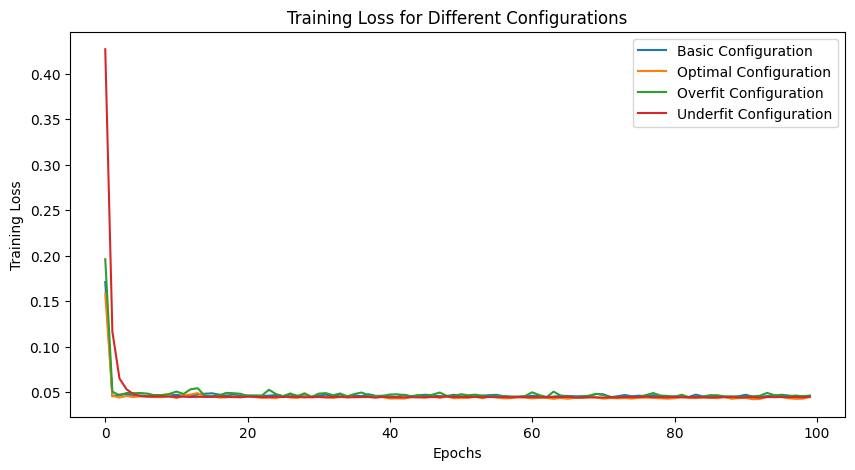

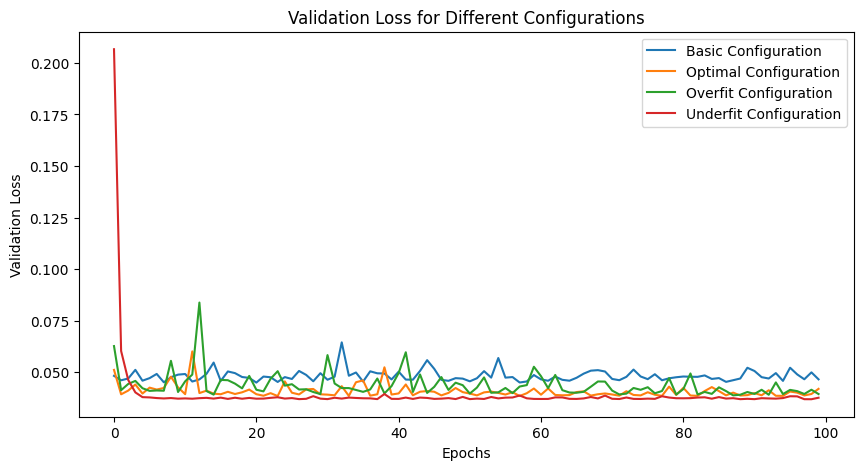

In [54]:
# plot training losses
plt.figure(figsize=(10, 5))
for config_name, (train_losses, val_losses) in training_results.items():
    plt.plot(train_losses, label=f"{config_name}")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss for Different Configurations")
plt.legend()
plt.show()

# plot validation losses
plt.figure(figsize=(10, 5))
for config_name, (train_losses, val_losses) in training_results.items():
    plt.plot(val_losses, label=f"{config_name}")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss for Different Configurations")
plt.legend()
plt.show()


![training](/Users/mariacalvo/Desktop/hm-professional-pytorch-template-mariaccalvo/training.png)
At about 5 epochs, all configurations converge. The basic, optimal, and overfit configurations all end up hitting a training loss of about 0.05 at the same time, while the underfit reaches 0.05 a bit after the rest. The former three all perform decently, while the ladder is probably over regularized. 

![validation](/Users/mariacalvo/Desktop/hm-professional-pytorch-template-mariaccalvo/validation.png)
The basic, optimal, and overfit configurations all have fluctuation. The overfit configuration has the most drastic fluctuations, which shows overfitting. The optimal configuration has the least. Over time, it reaches the most stable and lowest loss. The basic configuration indicate instability, due to having more fluctuations than the optimal configuration. The underfit configuration, however, indicates poor generalization.

#### 4. Analyzes overfitting and underfitting cases, and 5. Documents findings and conclusions

#### Basic Configuration

![basic](basic.png)

The training accuracy fluctuates between 0.130 and 0.140, which indicates weak larning. The validaton accuracy fluctuates between 0.145 and 0.180. This is an abnormal event of the validation accuracy being higher than the training accuracy. 

The training loss, however, drops to 0.045 quickly from 0.055, and then stabilizes. The validation loss, on the other hand, has small fluctuations and stays between 0.044 and 0.048. Both loss curves don't diverge too much, showing robust under or overfitting isn't occuring. 

Time per epoch range from 0.14 to 0.28 seconds. There are spikes, however, arguably indicate variation in training time. This could be from perhaps differing batch sizes. The results are a bit erratic.

Overall, the accruacy is somewhat stable, and the loss curves coverge nicely and indicate stability. There is not strong indication of strong overfitting. However, the model indicates weak learning from the low accuracy, even though it is stable. Additionally, the validaton accuracy was greater than the training accuracy, which could indicate aggressive model regularization or the training data being more noisy or complicated than the validation data.

The basic configuration could've performed like this due to the learning rate being too small or the model being too simple. Some recommendations for improvement is by increasing the learning rate or increasing model complexity.

#### Optimal Configuration

![optimal](optimal.png)

The training accuracy for the optimal configuration fluctuates between 0.130 and 0.145, showing a slightly better trend than the basic configuration. The validation accuracy ranges between 0.160 and 0.185, remaining consistently higher. Like before, this is an abnormal pattern where validation accuracy exceeds training accuracy, and may indicate regularization effects.

Training loss drops quickly from around 0.054 to roughly 0.046 and stays fairly stable. The validation loss, however, shows a more refined curve than in the basic configuration, with smaller fluctuations between 0.036 and 0.044. These loss curves and their convergence show an improved model learning and more stability, compared to the basic setup.

Time per epoch for this configuration stays between 0.14 and 0.26 seconds, following a similar pattern as before with a few spikes. These spikes still suggest variability during training, possibly due to batch composition, but nothing too concerning.

Overall, this configuration shows smoother curves and better convergence. Accuracy remains relatively low, but is higher and more stable than the basic configuration. The validation loss is lower and more consistent, which indicates improved generalization. Like the basic configuration, there’s no strong indication of overfitting or underfitting. Additionally, the training process appears stable.

This configuration likely performed better due to more appropriate hyperparameters, a deeper model, or improved learning rate. To make it even stronger, one could try fine-tuning the learning rate further. The model may also benefit from slightly more training epochs or an increase in hidden layer size.

#### Overfit Configuration

![overfit](overfit.png)

The training accuracy for the overfit configuration fluctuates between 0.128 and 0.142. The validation accuracy ranges from 0.135 to 0.185, once again showing the pattern of validation accuracy being higher than training accuracy. While some small upward trends are visible, the erratic variation in both curves makes the training behavior seem unstable.

The training loss starts around 0.054 and gradually lowers to about 0.046, but with several small spikes. The validation loss, however, shows much more noise, ranging from 0.036 to 0.049. These spikes and oscillations, especially in the validation loss, suggest that the model may be overfitting the training data and not generalizing well.

Time per epoch stays between 0.18 and 0.26 seconds, with multiple spikes like the previous configurations. These variations might result from different batch contents.

Overall, while the loss curves appear to converge, the accuracy fluctuates too much and doesn't reflect strong learning. The validation loss curve, in particular, is less smooth than in the basic or optimal configurations. These signs, along with the name of the configuration, suggest that the model has started to overfit by adapting too well to the training data without stable improvements in generalization.

This overfitting could have been caused by a model that is too complex for the task by perhaps too many parameters. Recommendations for improvement would be to reduce the model’s complexity slightly to prevent the model from learning noise in the training data.

#### Underfit Configuration

![underfit](underfit.png)

The training accuracy for the underfit configuration starts around 0.128, and steadily increases to just above 0.140 before flattening. The validation accuracy ranges from approximately 0.135 to 0.165, showing a moderate climb early on and then stabilizing. This early plateauing in both curves suggests that the model quickly reached the limits of what it could learn, and wasn't able to improve further.

The training loss drops very quickly from around 0.055 to 0.045 within the first few epochs, and stays almost flat from that point on. The validation loss follows a nearly identical trend, dropping fast and settling between 0.042 and 0.044. Both loss curves are extremely smooth with minimal fluctuation, which shows stability, but the early flattening is a sign that the model stopped learning relatively quickly.

Time per epoch is more efficient in this configuration, ranging between 0.13 and 0.22 seconds. There are occasional small spikes, but overall, the training time appears faster and more consistent than the other configurations, possibly because the model is smaller or less complex.

Overall, the accuracy plateaus early and stays low, while the loss curves show quick convergence without further improvement. This indicates clear underfitting, where the model is too simple to capture the patterns in the data. The stability in training and validation loss can be a good sign, but it reflects the model's limited learning capacity, rather than effective generalization.

This configuration likely performed this way due to a model that’s too shallow, a learning rate that’s too low, or regularization that’s too strong. To improve, the model could benefit from increased complexity, such as more layers or neurons, or a slightly higher learning rate.

### Disclaimer to Professor
I don't know why but sometiems it doesn't find base or configs in the root folder, but it's there. I got my code to work earlier, and then I just tried rerunning it one more time before submission and it's not running the same. But it did work at some point, hence the TensorBoard working.